<a href="https://colab.research.google.com/github/filmerxyz/JSTP-22_SkinDiseaseClassificationUsingMachineLearning/blob/master/7_Scratch_Focal_DenseNet121.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Check GPU

In [0]:
!nvidia-smi

Tue Jun  9 06:51:13 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

# Import Libraries

In [0]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras import models
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Activation, Flatten, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import regularizers
from tensorflow.keras.utils import Sequence
from imblearn.over_sampling import RandomOverSampler
from imblearn.keras import balanced_batch_generator

from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight, compute_sample_weight, compute_class_weight
from sklearn.metrics import balanced_accuracy_score, classification_report, confusion_matrix

import pandas as pd
import numpy as np
import os
import math
import itertools
from PIL import Image
from matplotlib import pyplot as plt

from ham10000_utils_functions import *

In [0]:
tf.compat.v1.disable_eager_execution()

In [0]:
IMG_WIDTH = 224
IMG_HEIGHT = 224
EPOCHS = 100
BATCH_SIZE = 32
NUM_CLASSES = 7

LR = 3e-5 # Learning rate

# Data

In [0]:
!git clone https://github.com/filmerxyz/HAM10000_split

Cloning into 'HAM10000_split'...
remote: Enumerating objects: 3, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 10065 (delta 0), reused 1 (delta 0), pack-reused 10062
Receiving objects: 100% (10065/10065), 2.57 GiB | 53.52 MiB/s, done.
Resolving deltas: 100% (8/8), done.
Checking out files: 100% (10021/10021), done.


In [0]:
train_path = '/content/HAM10000_split/train' 
val_path = '/content/HAM10000_split/val'
test_path = '/content/HAM10000_split/test'

In [0]:
train_aug = ImageDataGenerator(rescale=1./255,
                               rotation_range=360,
                               zoom_range=0.1,
                               width_shift_range=0.1,
                               height_shift_range=0.1,
                               horizontal_flip=True,
                               vertical_flip=True,
                               fill_mode='reflect')

val_aug = ImageDataGenerator(rescale=1./255)

test_aug = ImageDataGenerator(rescale=1./255)

In [0]:
train_generator = train_aug.flow_from_directory(train_path, 
                                                target_size=(IMG_WIDTH, IMG_HEIGHT), 
                                                batch_size=BATCH_SIZE, 
                                                shuffle=True,
                                                class_mode='categorical') 

val_generator = val_aug.flow_from_directory(val_path, 
                                              target_size=(IMG_WIDTH, IMG_HEIGHT), 
                                              batch_size=BATCH_SIZE, 
                                              shuffle=True,
                                              class_mode='categorical') 

test_generator = test_aug.flow_from_directory(test_path, 
                                               target_size=(IMG_WIDTH, IMG_HEIGHT), 
                                               batch_size=1, 
                                               shuffle=False,
                                               class_mode=None) 

Found 6303 images belonging to 7 classes.
Found 2707 images belonging to 7 classes.
Found 1005 images belonging to 7 classes.


# Model

## Build

In [0]:
def build_model():
  base_model = tf.keras.applications.DenseNet121(include_top=False, input_shape=(224, 224, 3), weights='imagenet')
  
  # for layer in base_model.layers:
  #   if isinstance(layer, BatchNormalization):
  #       layer.trainable = True
  #   else:
  #       layer.trainable = False

  average_pooling_layer = GlobalAveragePooling2D()(base_model.output)
  
  # fc_layer = Dense(128, activation='relu')(average_pooling_layer)
  # fc_layer = Dense(64, activation='relu')(fc_layer)
  # fc_layer = Dense(32, activation='relu')(fc_layer)
  # bn_layer = BatchNormalization()(fc_layer)
  # dropout_layer = Dropout(0.25)(bn_layer)
  prediction_layer = Dense(units=7, activation='softmax', name='prediction')(average_pooling_layer)

  model = Model(inputs=base_model.input, outputs=prediction_layer)

  return model

In [0]:
model = build_model()

In [0]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d_2 (ZeroPadding2D (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d_2[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
____________________________________________________________________________________________

## Focal Loss
https://github.com/umbertogriffo/focal-loss-keras

$$\text{FL}(p_t) = -\alpha_t (1 - p_t)^{\gamma} \, \text{log}(p_t)$$

In [0]:
def categorical_focal_loss(gamma=2., alpha=.25):
    """
    Softmax version of focal loss.
           m 
      FL = ∑  -alpha * (1 - p_o,c)^gamma * y_o,c * log(p_o,c)
          c=1
      where m = number of classes, c = class and o = observation
    Parameters:
      alpha -- the same as weighing factor in balanced cross entropy
      gamma -- focusing parameter for modulating factor (1-p)
    Default value:
      gamma -- 2.0 as mentioned in the paper
      alpha -- 0.25 as mentioned in the paper
    References:
        Official paper: https://arxiv.org/pdf/1708.02002.pdf
        https://www.tensorflow.org/api_docs/python/tf/keras/backend/categorical_crossentropy
    Usage:
     model.compile(loss=[categorical_focal_loss(alpha=.25, gamma=2)], metrics=["accuracy"], optimizer=adam)
    """
    def categorical_focal_loss_fixed(y_true, y_pred):
        """
        :param y_true: A tensor of the same shape as `y_pred`
        :param y_pred: A tensor resulting from a softmax
        :return: Output tensor.
        """

        # Scale predictions so that the class probas of each sample sum to 1
        y_pred /= K.sum(y_pred, axis=-1, keepdims=True)

        # Clip the prediction value to prevent NaN's and Inf's
        epsilon = K.epsilon()
        y_pred = K.clip(y_pred, epsilon, 1. - epsilon)

        # Calculate Cross Entropy
        cross_entropy = -y_true * K.log(y_pred)

        # Calculate Focal Loss
        loss = alpha * K.pow(1 - y_pred, gamma) * cross_entropy

        # Compute mean loss in mini_batch
        return K.mean(loss, axis=1)

    return categorical_focal_loss_fixed

## Compile

In [0]:
model.compile(optimizer=Adam(LR), 
              loss=categorical_focal_loss(gamma=2., alpha=.25),
              metrics=['accuracy'])

## Callbacks

In [0]:
early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')

model_checkpoint = ModelCheckpoint(filepath='7_scratch_focal_densenet121_model.h5', save_best_only=True, monitor='val_loss', mode='min')

reduce_lr_rate = ReduceLROnPlateau(monitor='val_loss', factor=0.3, min_lr=1e-7, patience=10, verbose=1, min_delta=1e-4, mode='min')

## Training

In [0]:
history = model.fit(train_generator,
                    validation_data=val_generator,
                    epochs=EPOCHS,
                    callbacks=[early_stop, model_checkpoint, reduce_lr_rate],
                    verbose=1)

Epoch 1/100
197/197 [==============================] - 419s 2s/step - loss: 0.0195 - accuracy: 0.7000 - val_loss: 0.0250 - val_accuracy: 0.6476 - lr: 3.0000e-05
Epoch 2/100
197/197 [==============================] - 173s 880ms/step - loss: 0.0121 - accuracy: 0.7758 - val_loss: 0.0173 - val_accuracy: 0.7255 - lr: 3.0000e-05
Epoch 3/100
197/197 [==============================] - 174s 884ms/step - loss: 0.0093 - accuracy: 0.8129 - val_loss: 0.0116 - val_accuracy: 0.7809 - lr: 3.0000e-05
Epoch 4/100
197/197 [==============================] - 174s 885ms/step - loss: 0.0078 - accuracy: 0.8336 - val_loss: 0.0094 - val_accuracy: 0.8175 - lr: 3.0000e-05
Epoch 5/100
197/197 [==============================] - 174s 882ms/step - loss: 0.0067 - accuracy: 0.8526 - val_loss: 0.0100 - val_accuracy: 0.8075 - lr: 3.0000e-05
Epoch 6/100
197/197 [==============================] - 175s 887ms/step - loss: 0.0061 - accuracy: 0.8648 - val_loss: 0.0093 - val_accuracy: 0.8190 - lr: 3.0000e-05
Epoch 7/100
197/197

# Graph

## Accuracy

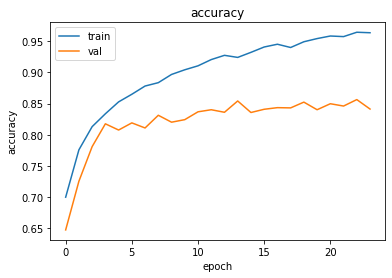

In [0]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('accuracy')
plt.show()

## Loss

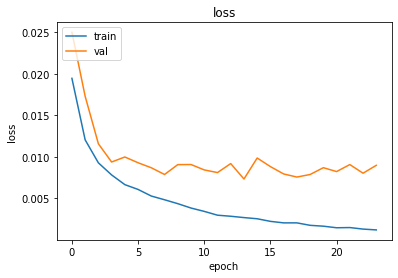

In [0]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('loss')
plt.show()

## Evaluate

In [0]:
import dill

In [0]:
custom_object = {'categorical_focal_loss_fixed': dill.loads(dill.dumps(categorical_focal_loss(gamma=2., alpha=.25))),
                 'categorical_focal_loss': categorical_focal_loss}

In [0]:
test_model = tf.keras.models.load_model('/content/7_scratch_focal_densenet121_model.h5', custom_objects=custom_object)

In [0]:
num_test_files = len(test_generator.filenames)

In [0]:
test_generator.reset()

In [0]:
test_labels = test_generator.classes
predictions = test_model.predict(test_generator, steps=num_test_files//test_generator.batch_size)

## Confusion Matrix

### Without Normalize

Confusion matrix, without normalization
[[ 22   4   6   0   0   1   0]
 [  2  44   3   0   1   2   0]
 [  3   3  87   0   8   9   0]
 [  1   1   0   6   1   3   0]
 [  2   1   9   0  73  27   0]
 [  2   7  12   0  24 626   0]
 [  0   1   0   0   0   2  12]]


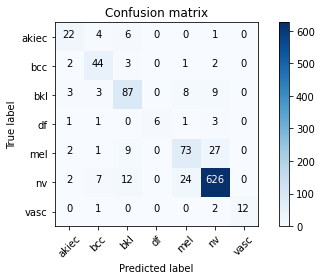

In [0]:
cm = confusion_matrix(test_labels, predictions.argmax(axis=1))

classes_names = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']

plot_confusion_matrix(cm, classes_names, False)

### With Normalize

Normalized confusion matrix
[[0.66666667 0.12121212 0.18181818 0.         0.         0.03030303
  0.        ]
 [0.03846154 0.84615385 0.05769231 0.         0.01923077 0.03846154
  0.        ]
 [0.02727273 0.02727273 0.79090909 0.         0.07272727 0.08181818
  0.        ]
 [0.08333333 0.08333333 0.         0.5        0.08333333 0.25
  0.        ]
 [0.01785714 0.00892857 0.08035714 0.         0.65178571 0.24107143
  0.        ]
 [0.00298063 0.01043219 0.01788376 0.         0.03576751 0.93293592
  0.        ]
 [0.         0.06666667 0.         0.         0.         0.13333333
  0.8       ]]


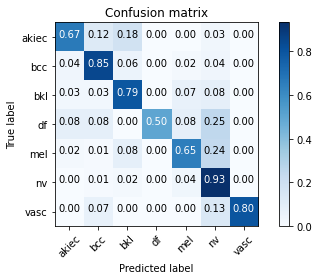

In [0]:
plot_confusion_matrix(cm, classes_names, True)

## Classification Report

In [0]:
y_pred = np.argmax(predictions, axis=1)
print('Confusion Matrix')
print(confusion_matrix(test_labels, y_pred))
print('Classification Report')
print(classification_report(test_labels, y_pred, target_names=classes_names))

Confusion Matrix
[[ 22   4   6   0   0   1   0]
 [  2  44   3   0   1   2   0]
 [  3   3  87   0   8   9   0]
 [  1   1   0   6   1   3   0]
 [  2   1   9   0  73  27   0]
 [  2   7  12   0  24 626   0]
 [  0   1   0   0   0   2  12]]
Classification Report
              precision    recall  f1-score   support

       akiec       0.69      0.67      0.68        33
         bcc       0.72      0.85      0.78        52
         bkl       0.74      0.79      0.77       110
          df       1.00      0.50      0.67        12
         mel       0.68      0.65      0.67       112
          nv       0.93      0.93      0.93       671
        vasc       1.00      0.80      0.89        15

    accuracy                           0.87      1005
   macro avg       0.82      0.74      0.77      1005
weighted avg       0.87      0.87      0.87      1005



## Model Analysis

In [0]:
w_num = 0.68 + 0.78 + 0.77 + 0.67 + 0.67 + 0.93 + 0.89 /7

In [0]:
MD = (abs(0.87-0.68) + abs(0.87-0.78) + abs(0.87-0.77) + abs(0.87-0.67)+ abs(0.87-0.67) + abs(0.87-0.93) + abs(0.87-0.89)) / w_num

### Low

In [8]:
0.87 - MD

0.6841401667181229

### High

In [9]:
0.87 + MD

1.0558598332818772

# Grad-CAM

In [0]:
last_conv2d = 'conv5_block16_concat'

## AKIEC

In [0]:
akiec_img = '/content/HAM10000_split/train/akiec/ISIC_0026492.jpg'

Model prediction:
	mel            	(4)	with probability 0.995
	nv             	(5)	with probability 0.004
	bkl            	(2)	with probability 0.001
	bcc            	(1)	with probability 0.000
	akiec          	(0)	with probability 0.000
Explanation for 'mel'


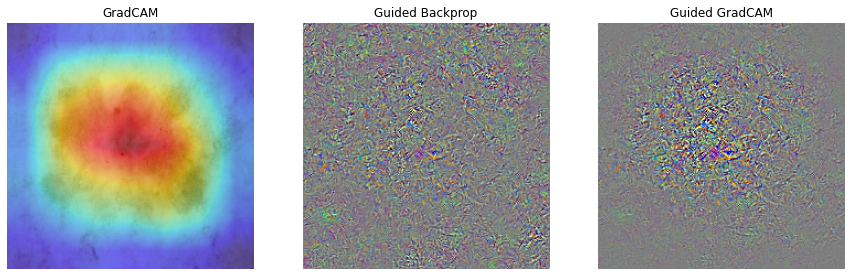

In [0]:
gradcam, gb, guided_gradcam = compute_saliency(model, model, akiec_img, layer_name=last_conv2d)

## BCC

In [0]:
bcc_img = '/content/HAM10000_split/train/bcc/ISIC_0024332.jpg'

Model prediction:
	mel            	(4)	with probability 0.590
	nv             	(5)	with probability 0.216
	bcc            	(1)	with probability 0.108
	bkl            	(2)	with probability 0.069
	akiec          	(0)	with probability 0.013
Explanation for 'mel'


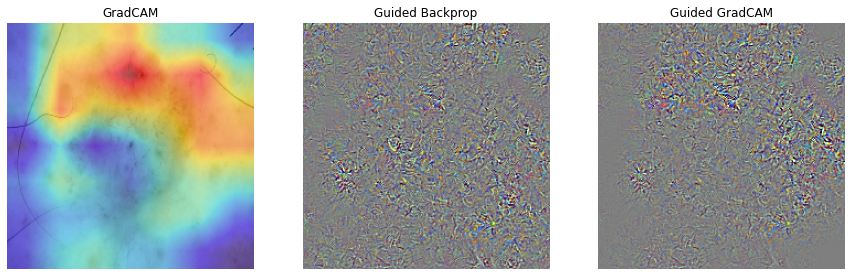

In [0]:
gradcam, gb, guided_gradcam = compute_saliency(model, model, bcc_img, layer_name=last_conv2d)

## BKL

In [0]:
bkl_img = '/content/HAM10000_split/train/bkl/ISIC_0025548.jpg'

Model prediction:
	mel            	(4)	with probability 0.533
	nv             	(5)	with probability 0.464
	bkl            	(2)	with probability 0.003
	vasc           	(6)	with probability 0.000
	bcc            	(1)	with probability 0.000
Explanation for 'mel'


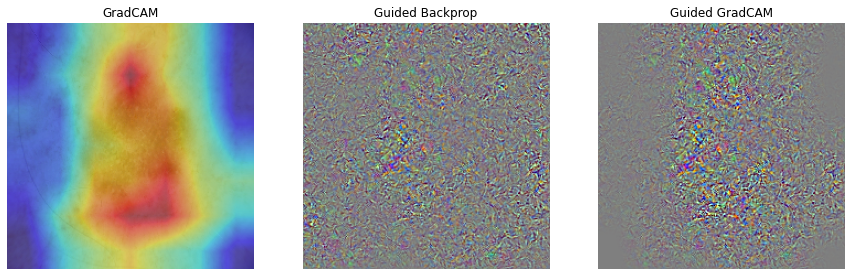

In [0]:
gradcam, gb, guided_gradcam = compute_saliency(model, model, bkl_img, layer_name=last_conv2d)

## DF

In [0]:
df_img = '/content/HAM10000_split/val/df/ISIC_0033626.jpg'

Model prediction:
	mel            	(4)	with probability 0.597
	nv             	(5)	with probability 0.402
	df             	(3)	with probability 0.000
	vasc           	(6)	with probability 0.000
	bkl            	(2)	with probability 0.000
Explanation for 'mel'


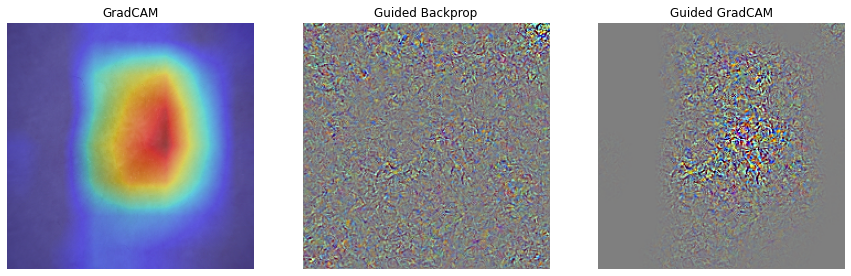

In [0]:
gradcam, gb, guided_gradcam = compute_saliency(model, model, df_img, layer_name=last_conv2d)

## MEL

In [0]:
mel_img = '/content/HAM10000_split/train/mel/ISIC_0024516.jpg'

Model prediction:
	mel            	(4)	with probability 0.671
	nv             	(5)	with probability 0.329
	bkl            	(2)	with probability 0.000
	akiec          	(0)	with probability 0.000
	vasc           	(6)	with probability 0.000
Explanation for 'mel'


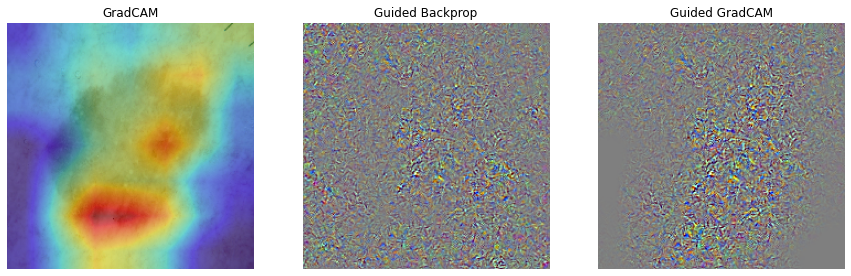

In [0]:
gradcam, gb, guided_gradcam = compute_saliency(model, model, mel_img, layer_name=last_conv2d)

## NV

In [0]:
nv_img = '/content/HAM10000_split/val/nv/ISIC_0024349.jpg'

Model prediction:
	mel            	(4)	with probability 0.557
	nv             	(5)	with probability 0.442
	bkl            	(2)	with probability 0.001
	vasc           	(6)	with probability 0.000
	df             	(3)	with probability 0.000
Explanation for 'mel'


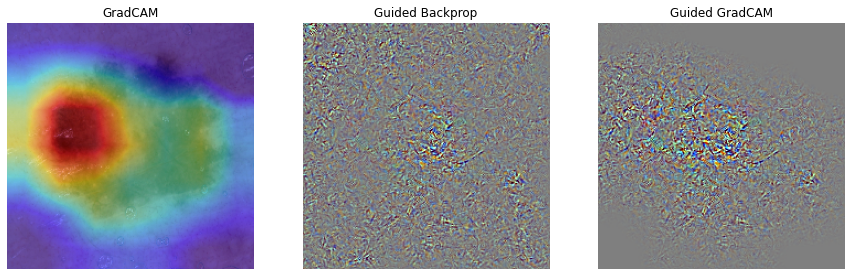

In [0]:
gradcam, gb, guided_gradcam = compute_saliency(model, model, nv_img, layer_name=last_conv2d)

## VASC

In [0]:
vasc_img = '/content/HAM10000_split/test/vasc/ISIC_0025452.jpg'

Model prediction:
	vasc           	(6)	with probability 0.813
	nv             	(5)	with probability 0.183
	bkl            	(2)	with probability 0.004
	mel            	(4)	with probability 0.000
	akiec          	(0)	with probability 0.000
Explanation for 'vasc'


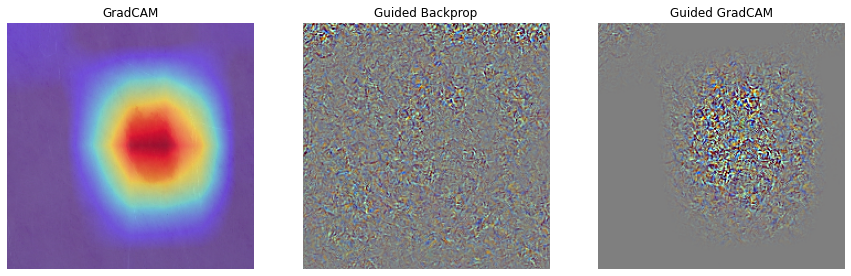

In [0]:
gradcam, gb, guided_gradcam = compute_saliency(model, model, vasc_img, layer_name=last_conv2d)

# Download

In [0]:
from google.colab import files

files.download('/content/7_scratch_focal_densenet121_model.h5')